In [13]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [78]:
head = ['user id', 'item id', 'rating', 'timestamp']
df_movies = pd.read_csv('ml-100k/u.data', sep='\t', names=head)

In [80]:
nb_users = len(df_movies['user id'].unique())
nb_items = len(df_movies['item id'].unique())

In [27]:
df_movies

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [19]:
def create_R_matrix(df_movies, n_users, n_items):
    
    R = pd.DataFrame(index=np.arange(1, n_items+1), columns=np.arange(1, n_users+1))
    groups = df_movies.groupby('user id')
    for name, group in groups:
        movies_rated = group['item id'].unique()
        R.loc[movies_rated, name] = group['rating'].values
    R=R.fillna(0)
    return(R.values)

On sépare notre matrice en un train set et un test set

In [20]:
train_set, test_set = train_test_split(df_movies, test_size = 0.1)

In [21]:
test_set

,user id,item id,rating,timestamp
19233,373,559,3,877106305
80615,741,682,3,891455960
61401,357,932,4,878952341
8856,311,510,4,884366545
99851,23,227,3,874787738
...,...,...,...,...
90759,268,449,2,875744357
45089,336,1079,1,877757094
36311,297,249,3,874955210
17458,5,457,1,879198898


<h1>Stochastic Gradient Descent</h1>

In [8]:
class SGD:
    def __init__(self, k, nb_users, nb_items, nb_iter=1000, mu = 0.2, lambda_ = 0.2, eta = 0.0005, zeta = 0.0005, eps = 0.1):
        self.k_components = k
        self.nb_iterations = nb_iter
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.mu = mu
        self.lambda_ = lambda_
        self.eta = eta
        self.zeta = zeta
        self.eps = eps
        self.I = 2*np.random.random((self.nb_items, self.k_components))-1.0
        self.U = 2*np.random.random((self.nb_users, self.k_components))-1.0
        
    def cost(self, R, ITI, UTU):
        return(np.trace(np.dot(R.T, R)) - 2*np.trace(np.dot(R.T, np.dot(self.I, self.U.T))) + np.trace(np.dot(self.U, np.dot(ITI, self.U.T))) + self.lambda_*np.trace(UTU) + self.mu*np.trace(ITI))
    
    def fit(self, X):
        R = create_R_matrix(X, self.nb_users, self.nb_items)
        compt = 0
        ITI = np.dot(self.I.T, self.I)
        UTU = np.dot(self.U.T, self.U)
        tempI = self.I
        tempU = self.U
        while compt<self.nb_iterations: #self.cost(R, ITI, UTU)>self.eps and compt<self.nb_iterations:
            compt+=1
            tempI += -self.eta*(-2*np.dot(R, self.U) + 2*np.dot(self.I, UTU) + 2*self.lambda_*self.I)
            tempU += -self.zeta*(-2*np.dot(R.T, self.I) + 2*np.dot(self.U, ITI) + 2*self.mu*self.U)
            self.I = tempI
            self.U = tempU
            ITI = np.dot(self.I.T, self.I)
            UTU = np.dot(self.U.T, self.U)
        print(self.cost(R, ITI, UTU))
    
    def predict(self, X):
        y = []
        #print(X.apply(lambda x: self.U[x['user id']-1].dot(self.I[x['item id']-1]), axis=1))
        for x in X.iterrows():
            y.append(np.dot(self.U[x[1]['user id']-1], self.I[x[1]['item id']-1]))
        return(y)

In [ ]:
model=SGD(k=40, nb_users=162541, nb_items=62423, nb_iter=4)
model.fit(train_set)

In [575]:
preds = model.predict(test_set)
print(mean_squared_error(test_set['rating'].values, preds, squared=False))

2.7705017205517595


In [576]:
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
rmse = []
for train_index, test_index in kf.split(df_movies):
    train_set = df_movies.loc[train_index]
    test_set = df_movies.loc[test_index]
    model=SGD(k=40, nb_users=943, nb_items=1682, nb_iter=450)
    model.fit(train_set)
    preds = model.predict(test_set)
    rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))

543849.6756267888
539333.8248191372
541767.8250556207
541551.24195398
540460.2433240009


In [578]:
print(np.mean(rmse))

2.8052593255590574


<h1>Alternated least square</h1>

In [15]:
class ALS:
    def __init__(self, k, nb_users, nb_items, nb_iter=1000, mu = 0.2, lambda_ = 0.2, eps = 0.1):
        self.k_components = k
        self.nb_iterations = nb_iter
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.mu = mu
        self.lambda_ = lambda_
        self.eps = eps
        self.I = np.random.random((self.nb_items, self.k_components))
        self.U = np.random.random((self.nb_users, self.k_components))
        
    def cost(self, R, ITI, UTU):
        return(np.trace(np.dot(R.T, R)) - 2*np.trace(np.dot(R.T, np.dot(self.I, self.U.T))) + np.trace(np.dot(self.U, np.dot(ITI, self.U.T))) + self.lambda_*np.trace(UTU) + self.mu*np.trace(ITI))
    
    def fit(self, X):
        R = create_R_matrix(X, self.nb_users, self.nb_items)
        compt = 0
        ITI = np.dot(self.I.T, self.I)
        UTU = np.dot(self.U.T, self.U)
        tempI = self.I
        tempU = self.U
        while compt<self.nb_iterations: #self.cost(R, ITI, UTU)>self.eps and compt<self.nb_iterations:
            compt+=1
            tempI = np.dot(R, np.dot(self.U, np.linalg.inv(UTU + self.lambda_*np.eye(self.k_components))))
            tempU = np.dot(R.T, np.dot(self.I, np.linalg.inv(ITI + self.mu*np.eye(self.k_components))))
            self.I = tempI
            self.U = tempU
            ITI = np.dot(self.I.T, self.I)
            UTU = np.dot(self.U.T, self.U)
        print(self.cost(R, ITI, UTU))
    
    def predict(self, X):
        y = []
        #print(X.apply(lambda x: self.U[x['user id']-1].dot(self.I[x['item id']-1]), axis=1))
        for x in X.iterrows():
            y.append(np.dot(self.U[x[1]['user id']-1], self.I[x[1]['item id']-1]))
        return(y)

In [ ]:
train_set, test_set = train_test_split(df_movies, test_size = 0.2)

model=ALS(k=40, nb_users=n_users, nb_items=n_movies, nb_iter=2)
model.fit(train_set)

In [572]:
preds = model.predict(test_set)
print(mean_squared_error(test_set['rating'].values, preds, squared=False))

2.9277634076290084


In [573]:
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
rmse = []
for train_index, test_index in kf.split(df_movies):
    train_set = df_movies.loc[train_index]
    test_set = df_movies.loc[test_index]
    model=ALS(k=40, nb_users=943, nb_items=1682, nb_iter=700)
    model.fit(train_set)
    preds = model.predict(test_set)
    rmse.append(mean_squared_error(test_set['rating'].values, preds, squared=False))

1404131.8203530742
1489336.6828412232
1453903.253601181
1391472.0257790433
1451326.0721664997


In [574]:
print(np.mean(rmse))

2.8756809811546526


<h1>Avec matrices sparses</h1>

In [22]:
head = ['user id', 'item id', 'rating', 'timestamp']
df_movies = pd.read_csv('ml-25m/ratings.csv')

In [28]:
def remove_users(df_movies):
    groups = df_movies.groupby('userId').size()
    remove = list(groups[groups == 1].index)
    ret = df_movies[~(df_movies['userId'].isin(remove))]
    return(ret)

In [29]:
def create_mappers(df_movies):
    mapper_movies = {}
    mapper_users = {}
    cols_conv = df_movies['userId'].unique()
    compt = 0
    for i in cols_conv:
        mapper_users[i] = compt
        compt += 1
    rows_conv = df_movies['movieId'].unique()
    compt = 0
    for i in rows_conv:
        mapper_movies[i] = compt
        compt += 1
    return(mapper_movies, mapper_users)

In [30]:
def create_R_matrix_sparse(df_movies, n_users, n_movies, mapper_movies, mapper_users):
    cols = df_movies['userId'].map(mapper_users)
    rows = df_movies['movieId'].map(mapper_movies)
    ratings = df_movies['rating']
    sparseMatrix = csr_matrix((ratings, (rows, cols)), shape=(n_movies, n_users))
    return(sparseMatrix)

In [31]:
def create_test_set(df):
    groups = df.groupby('userId')
    test_ind = []
    for name, group in groups:
        L = list(group.index)
        ind = random.randint(0, len(L)-1)
        test_ind.append(L[ind])
    return(df.loc[test_ind], df.loc[~(df.index.isin(test_ind))])

In [32]:
n_users = len(df_movies['userId'].unique())
n_movies = len(df_movies['movieId'].unique())

df_movies = remove_users(df_movies)

In [33]:
test_set, train_set = create_test_set(df_movies)

In [34]:
class ALS_Sparse:
    def __init__(self, k, nb_users, nb_items, mapper_users, mapper_items, nb_iter=1000, mu = 0.1, lambda_ = 0.1, eps = 0.1):
        self.k_components = k
        self.nb_iterations = nb_iter
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.mu = mu
        self.lambda_ = lambda_
        self.eps = eps
        self.I = np.random.random((self.nb_items, self.k_components))
        self.U = np.random.random((self.nb_users, self.k_components))
        self.mapper_users = mapper_users
        self.mapper_items = mapper_items
        
    def cost(self, R, ITI, UTU):
        return(np.trace(R.transpose().dot(R)) - 2*np.trace(R.transpose().dot(np.dot(self.I, self.U.T))) + np.trace(np.dot(self.U, np.dot(ITI, self.U.T))) + self.lambda_*np.trace(UTU) + self.mu*np.trace(ITI))
    
    def fit(self, X, test_set):
        rmses = []
        R = create_R_matrix_sparse(X, self.nb_users, self.nb_items, self.mapper_items, self.mapper_users)
        compt = 0
        while compt<self.nb_iterations: #self.cost(R, ITI, UTU)>self.eps and compt<self.nb_iterations:
            compt += 1
            self.I = R.dot(self.U.dot(np.linalg.inv(self.U.T.dot(self.U) + self.lambda_*np.eye(self.k_components))))
            self.U = R.transpose().dot(self.I.dot(np.linalg.inv(self.I.T.dot(self.I) + self.mu*np.eye(self.k_components))))
            preds = self.predict(test_set)
            rmses.append(mean_squared_error(test_set['rating'].values, preds, squared=False))
        #print(rmses)
        return(rmses)
            
    def predict(self, X):
        y = []
        for x in X.iterrows():
            y.append(np.dot(self.I[self.mapper_items[int(x[1]['movieId'])]], self.U[self.mapper_users[int(x[1]['userId'])]].T))
        return(y)

In [92]:
k = [5, 10, 20]
rmses = []
for i in k:
    print(i)
    mapper_movies, mapper_users = create_mappers(df_movies)
    model=ALS_Sparse(mapper_users=mapper_users, mapper_items=mapper_movies, k=i, nb_users=n_users, nb_items=n_movies, nb_iter=50)
    rmses.append(model.fit(train_set, test_set))

5
10
20


Text(0.5, 1.0, 'rmse par rapport à nb_iter pour k=40')

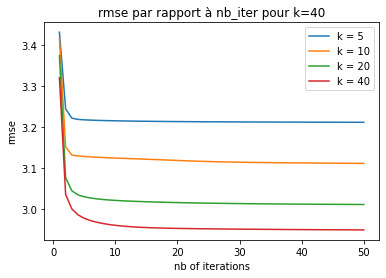

In [100]:
plt.plot(np.arange(1,51), rmses[0], label='k = 5')
plt.plot(np.arange(1,51), rmses[1], label='k = 10')
plt.plot(np.arange(1,51), rmses[2], label='k = 20')
plt.plot(np.arange(1,51), rmses[3], label='k = 40')
plt.legend()
plt.xlabel('nb of iterations')
plt.ylabel('rmse')
plt.title('rmse par rapport à nb_iter pour k=40')

In [81]:
preds = model.predict(test_set)
print(mean_squared_error(test_set['rating'].values, preds, squared=False))

2.949580279980083


In [55]:
rmsesK = []
for i in range(1, 30):
    print(i)
    model=ALS_Sparse(mapper_users=mapper_users, mapper_items=mapper_movies, k=i, nb_users=n_users, nb_items=n_movies, nb_iter=20)
    model.fit(train_set,test_set)
    preds = model.predict(test_set)
    rmsesK.append(mean_squared_error(test_set['rating'].values, preds, squared=False))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [73]:
for i in range(30, 55):
    print(i)
    model=ALS_Sparse(mapper_users=mapper_users, mapper_items=mapper_movies, k=i, nb_users=n_users, nb_items=n_movies, nb_iter=20)
    model.fit(train_set,test_set)
    preds = model.predict(test_set)
    rmsesK.append(mean_squared_error(test_set['rating'].values, preds, squared=False))

30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


Text(0.5, 1.0, 'rmse in relation to the number of components for nb_iter=20')

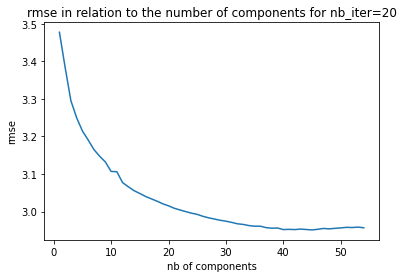

In [87]:
plt.plot(np.arange(1,55), rmsesK)
plt.xlabel('nb of components')
plt.ylabel('rmse')
plt.title('rmse in relation to the number of components for nb_iter=20')

In [75]:
print(rmsesK)

[3.477395686110603, 3.383387803024297, 3.295054958258163, 3.2497869238475907, 3.2147698931321695, 3.190859400668128, 3.165328140529528, 3.147443479597222, 3.132146090994368, 3.1068800418658866, 3.1062008982085123, 3.0771659748493105, 3.066084425911089, 3.05567408540689, 3.048240377201761, 3.040337951583965, 3.0340239621479, 3.027739216822297, 3.0207617666721247, 3.0153844907710607, 3.0088887981970593, 3.004312999766285, 3.000008922423756, 2.995807235427257, 2.9925885610444127, 2.9874257675077605, 2.9833948080067576, 2.980248967376061, 2.976918655303727, 2.9744707562281385, 2.9712912066723094, 2.9675729430028444, 2.9658828696230066, 2.9628053030808563, 2.9611124100356543, 2.9611881483583473, 2.957240220461113, 2.955925191807306, 2.9562481379183, 2.95220847508431, 2.952754801269876, 2.952174964500099, 2.953520756024214, 2.9523378461751726, 2.9512646764314074, 2.952957954204601, 2.955176523232552, 2.9540152766623846, 2.9554950551425034, 2.9566417770902205, 2.958125965911628, 2.95759111773

<h1>PCA with robustness to missing entries</h1>
<h2>Matrix completion by power factorization</h2>

In [48]:
from scipy.sparse import find
from numba import jit


#@jitclass([("I", float64[:, :]), ("U", float64[:, :]), ("mapper_users", typeof(mapper_users)), ("mapper_items", typeof(mapper_movies))])
class ALS_Sparse_zeros:
    k_components: int
    nb_iterations: int
    nb_users: int
    nb_items: int
    mu: float
    lambda_: float
    eps: float
    I: np.ndarray
    U: np.ndarray
    mapper_users: dict
    mapper_items: dict
    
    def __init__(self, k, nb_users, nb_items, mapper_users, mapper_items, nb_iter=1000, mu = 0.1, lambda_ = 0.1, eps = 0.1):
        self.k_components = k
        self.nb_iterations = nb_iter
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.mu = mu
        self.lambda_ = lambda_
        self.eps = eps
        self.I = np.random.random((self.nb_items, self.k_components))
        self.U = np.random.random((self.nb_users, self.k_components))
        self.mapper_users = mapper_users
        self.mapper_items = mapper_items
    
    def fit(self, X, test_set):
        rmses = []
        R = create_R_matrix_sparse(X, self.nb_users, self.nb_items, self.mapper_items, self.mapper_users)
        x, y, z = find(R)
        compt = 0
        while compt<self.nb_iterations: #self.cost(R, ITI, UTU)>self.eps and compt<self.nb_iterations:
            compt += 1
            tempU1 = np.zeros((self.nb_users, self.k_components, self.k_components))
            tempU2 = np.zeros((self.nb_users, self.k_components))
            tempI1, tempI2 = self.MAJ_I(x,y,z)
            for j in range(self.nb_items):
                tempI1[j] += self.lambda_*np.eye(self.k_components)
                self.I[j, :] = np.linalg.inv(tempI1[j]).dot(tempI2[j])
            print('here2')
            for i in zip(x,y,z):
                tempU1[i[1]] += self.I[i[0]].reshape((self.k_components,1)).dot(self.I[i[0]].reshape((self.k_components,1)).T)
                tempU2[i[1]] += i[2]*self.I[i[0]]
            for j in range(self.nb_users):
                tempU1[j] += self.mu*np.eye(self.k_components)
                self.U[j, :] = np.linalg.inv(tempU1[j]).dot(tempU2[j])
            preds = self.predict(test_set)
            rmses.append(mean_squared_error(test_set['rating'].values, preds, squared=False))
        print(rmses)
        return(rmses)
    
    def MAJ_I(self, x, y, z):
        tempI1 = np.zeros((self.nb_items, self.k_components, self.k_components))
        tempI2 = np.zeros((self.nb_items, self.k_components))
        c=0
        for i in zip(x,y,z):
            if (c%5000000 == 0):
                print(c)
            c+=1
            tempI1[i[0]] += self.U[i[1]].reshape((self.k_components,1)).dot(self.U[i[1]].reshape((self.k_components,1)).T)
            tempI2[i[0]] += i[2]*self.U[i[1]]
        return(tempI1, tempI2)
            
    def predict(self, X):
        y = []
        for x in X.iterrows():
            y.append(np.dot(self.I[self.mapper_items[int(x[1]['movieId'])]], self.U[self.mapper_users[int(x[1]['userId'])]].T))
        return(y)

In [49]:
mapper_movies, mapper_users = create_mappers(df_movies)

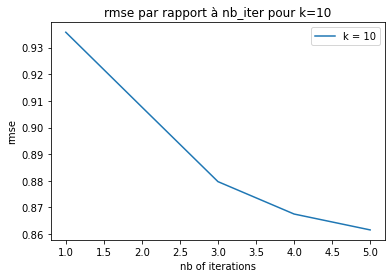

In [151]:
rmses2=[0.9357653977806198, 0.9076791122884633, 0.8796771006057957, 0.8675167814196174, 0.8615496071242486]
plt.plot(np.arange(1,6), rmses2, label='k = 10')
plt.legend()
plt.xlabel('nb of iterations')
plt.ylabel('rmse')
plt.title('rmse par rapport à nb_iter pour k=10')
plt.show()

## Tests de différents paramètres

#### K

In [50]:
K = [2, 5, 10, 20, 50]

In [52]:
Rmse_ALS_Sparse_zero_K = []
rmse_als_k = []
for k in K:
    print("k= ",k)
    model = ALS_Sparse_zeros(k=k, nb_users=n_users, nb_items=n_movies, nb_iter=10, mapper_users=mapper_users, mapper_items=mapper_movies)
    rmse_als_k.append(model.fit(train_set, test_set))
    Rmse_ALS_Sparse_zero_K.append(np.mean(rmse_als_k)) 

k=  2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
[0.877614347023373, 0.8715423890220666, 0.8658514650044283, 0.8608827957579939, 0.8581922359594336, 0.8568012054726298, 0.8559311548882771, 0.855220445639295, 0.8545801731492884, 0.8539723907126056]
k=  5
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
[0.8872961035423277, 0.8782344782384925, 0.8576863158406347, 0.8430830836398935, 0.8343418815608035, 0.828469

In [58]:
rmse_als_k = [[0.877614347023373, 0.8715423890220666, 0.8658514650044283, 0.8608827957579939, 0.8581922359594336, 0.8568012054726298, 0.8559311548882771, 0.855220445639295, 0.8545801731492884, 0.8539723907126056],[0.8872961035423277, 0.8782344782384925, 0.8576863158406347, 0.8430830836398935, 0.8343418815608035, 0.8284696846401127, 0.8247318799635666, 0.8223953776452154, 0.8209708343392738, 0.8201440519872796],[0.9049023772391739, 0.8856535800965954, 0.8633570850782882, 0.8482078804523288, 0.8382389220784583, 0.8317574604138209, 0.8275748678456574, 0.8247875395831192, 0.8229117320006643, 0.8216690582532542],[0.9381567615486188, 0.9129272209138962, 0.8895958014939431, 0.8742498006893044, 0.8654314504464644, 0.860578678191853, 0.8581190263352891, 0.857081562320388, 0.8568879788679606, 0.8572362049799974],[1.0259683584802022, 0.9839979836226662, 0.9600612224376142, 0.9482143288763167, 0.9443288428718867, 0.9448374696569711, 0.9475085401538532, 0.9512853245345924, 0.9556088418972583, 0.9601585215504409]]

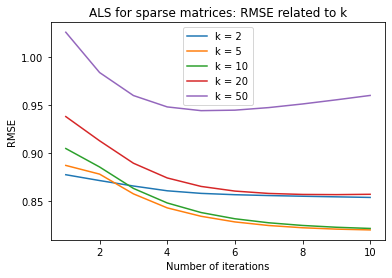

In [64]:
plt.plot(np.arange(1,11), rmse_als_k[0], label='k = 2')
plt.plot(np.arange(1,11), rmse_als_k[1], label='k = 5')
plt.plot(np.arange(1,11), rmse_als_k[2], label='k = 10')
plt.plot(np.arange(1,11), rmse_als_k[3], label='k = 20')
plt.plot(np.arange(1,11), rmse_als_k[4], label='k = 50')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.title('ALS for sparse matrices: RMSE related to k')
plt.show()

#### Lambda

In [75]:
Lambd = [0.1, 0.3, 0.5, 0.7, 0.9]

In [61]:
Rmse_ALS_Sparse_zero_Lambda = []
rmse_als_lambda = []
for l in Lambd:
    print("lambda= ",l)
    model = ALS_Sparse_zeros(k=5, nb_users=n_users, nb_items=n_movies, nb_iter=10, mapper_users=mapper_users, mapper_items=mapper_movies, lambda_=l)
    rmse_als_lambda.append(model.fit(train_set, test_set))
    Rmse_ALS_Sparse_zero_Lambda.append(np.mean(rmse_als_lambda)) 

lambda=  0.1
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
[0.8889065768774762, 0.8714322977132777, 0.8514374809282712, 0.8406265751983067, 0.8339620449337037, 0.8298632804897939, 0.8274534693523969, 0.8259872478570133, 0.8249814487760092, 0.8242019680548247]
lambda=  0.30000000000000004
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
[0.8846356223743502, 0.8667729882034867, 0.8469864187609762, 0.83623140807053

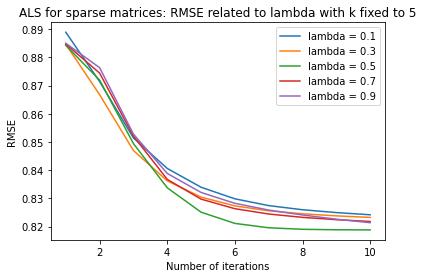

In [77]:
for i in range(len(Lambd)):
    plt.plot(np.arange(1,11), rmse_als_lambda[i], label='lambda = '+str(Lambd[i]))
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.title('ALS for sparse matrices: RMSE related to lambda with k fixed to 5')
plt.show()    

#### Mu

In [67]:
Mu = [0.1, 0.3, 0.5, 0.7, 0.9]

In [69]:
Rmse_ALS_Sparse_zero_Mu = []
rmse_als_mu = []
for m in Mu:
    print("mu= ",m)
    model = ALS_Sparse_zeros(k=5, nb_users=n_users, nb_items=n_movies, nb_iter=10, mapper_users=mapper_users, mapper_items=mapper_movies, lambda_=0.5, mu=m)
    rmse_als_mu.append(model.fit(train_set, test_set))
    Rmse_ALS_Sparse_zero_Lambda.append(np.mean(rmse_als_mu)) 

mu=  0.1
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
[0.883930340514724, 0.8663861170563512, 0.8470969444314884, 0.8363778721358509, 0.8297891436429441, 0.8260619897025424, 0.8241292464873013, 0.8231407657890714, 0.8226171412812789, 0.8223030219499596]
mu=  0.3
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
0
5000000
10000000
15000000
here2
[0.8796775482522294, 0.8616535648400084, 0.8397044960552653, 0.8297171807959919, 0.8242675415793342, 0

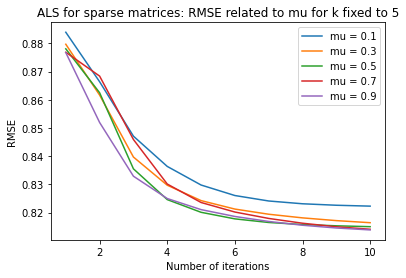

In [72]:
for i in range(len(Mu)):
    plt.plot(np.arange(1,11), rmse_als_mu[i], label='mu = '+str(Mu[i]))
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.title('ALS for sparse matrices: RMSE related to mu for k fixed to 5')
plt.show()